In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/cats-and-dogs.zip \
    -O /tmp/cats-and-dogs.zip

--2020-08-02 16:07:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/cats-and-dogs.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 74.125.129.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  59.9MB/s    in 9.0s    

2020-08-02 16:08:08 (87.6 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [2]:
import os 
import zipfile 
import tensorflow as tf

In [3]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/cat-and-dogs')

In [4]:
zip_ref.close()

In [5]:
print(len(os.listdir('/tmp/cat-and-dogs/PetImages/Cat/')))
print(len(os.listdir('/tmp/cat-and-dogs/PetImages/Dog/')))


12501
12501


In [6]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    os.mkdir('/tmp/cats-v-dogs/')
    
    os.makedirs('/tmp/cats-v-dogs/training/cats/')
    os.makedirs('/tmp/cats-v-dogs/training/dogs/')
    
    os.makedirs('/tmp/cats-v-dogs/testing/cats')
    os.makedirs('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [8]:

# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
import shutil
from shutil import copyfile
from os import getcwd
import random
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    All_data=os.listdir(SOURCE)
    for i in range(1500):  # using only 1500 images because some files are corrupted and taking long time
        if len(All_data[i]) == 0:
            All_data.remove(All_data(i))
    Train_size = int(1500*SPLIT_SIZE)
    Test_size = int(1500*(1-SPLIT_SIZE))
    
    Training_data = All_data[0:Train_size]
    Test_data = All_data[Train_size:Train_size+Test_size+1]
    
    for i in Training_data:
        shutil.move(SOURCE + '/'+i, TRAINING +'/'+i)
    for i in Test_data:
        shutil.move(SOURCE + '/'+i, TESTING +'/'+i)
    


CAT_SOURCE_DIR = "/tmp/cat-and-dogs/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/cat-and-dogs/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [9]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

1350
1350
150
150


In [10]:
model = tf.keras.models.Sequential([
  # 1st conv net 
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape = (150, 150, 3)), 
  tf.keras.layers.MaxPooling2D(2,2),

  # 2nd Conv
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'), 
  tf.keras.layers.MaxPooling2D(2,2),

  # 3rd Conv
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
  tf.keras.layers.MaxPooling2D(2,2), 

  # Flattern layer
  tf.keras.layers.Flatten(), 

  # 512 neuron hidden layer
  tf.keras.layers.Dense(units=512, activation='relu'), 

  # output layer
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [11]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [12]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/'
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True, 
    fill_mode = 'nearest'
)

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR, 
    target_size = (150, 150), 
    batch_size = 10, 
    class_mode = 'binary'
)

VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

validation_generator =validation_datagen.flow_from_directory(
    VALIDATION_DIR, 
    target_size = (150, 150), 
    batch_size = 10, 
    class_mode = 'binary'
)



Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [13]:
history = model.fit_generator(train_generator,
                              epochs=2,
                              verbose=1,
                              validation_data=validation_generator)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
 29/270 [==>...........................] - ETA: 1:05 - loss: 0.8815 - acc: 0.5517

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

270/270 [==============================] - 77s 284ms/step - loss: 0.7136 - acc: 0.5452 - val_loss: 0.6527 - val_acc: 0.6067
Epoch 2/2
270/270 [==============================] - 76s 283ms/step - loss: 0.6681 - acc: 0.5926 - val_loss: 0.6778 - val_acc: 0.5400


Text(0.5, 1.0, 'Training and validation loss')

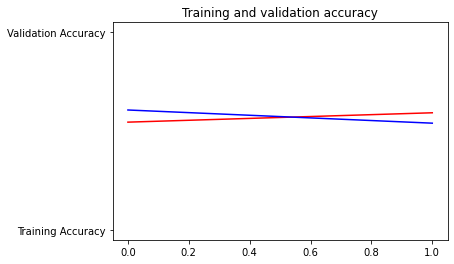

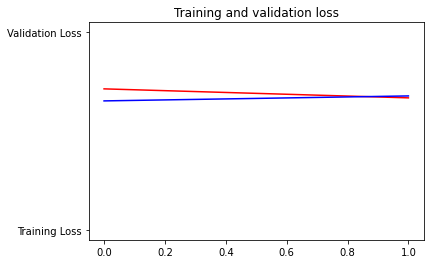

In [14]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')